# Face Generative Adversial Network 

Challenge_1: Use the CelebA dataset to generate realistic faces using a DCGAN <br>
Challenge_2: Understand and extract the internal structure of the faces to create customizable and unique faces<br>
Challenge_3: Face interpolation
Challenge_4: ProGAN 

In [1]:
# load libraries 
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np 
import matplotlib.pyplot as plt
import cv2
import os 

# device gpu device
device = torch.device("cuda") 

data_dir = "data/img_align_celeba/"

image_list = [os.path.join(data_dir, i)
              for i in os.listdir(data_dir)]

### Create Dataset

The data transformation pipeline resizes and crops the image to a square 64x64 pixels, finally it normalizes the values between -1 and 1 

In [2]:
imsize = 64
n_channels = 3
latent_size = 100

transform = transforms.Compose(
    [transforms.Resize(imsize),
     transforms.CenterCrop(imsize),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # normalize between [-1 1]


dataset = torchvision.datasets.ImageFolder(root="data/",
                           transform=transform)

batch_size = 32

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2,
                                         pin_memory=True)


## GAN MODEL

### Train Model

In [3]:
from models.GAN.GAN import GAN 

save_dir = "models/GAN/model_states/"


model = GAN(device=device, save_dir=save_dir)
model.compile()



In [4]:
n_epochs = 23
model.train(dataloader, n_epochs)

[0/23][0/6332]	Loss_D: 1.4269	Loss_G: 3.9629	Acc_dis: 0.4945	Acc_gen: 0.5111 / 0.0197
[0/23][100/6332]	Loss_D: 0.6286	Loss_G: 5.8914	Acc_dis: 0.9807	Acc_gen: 0.4555 / 0.0028
[0/23][200/6332]	Loss_D: 0.6284	Loss_G: 5.0246	Acc_dis: 0.8888	Acc_gen: 0.3660 / 0.0090
[0/23][300/6332]	Loss_D: 0.6565	Loss_G: 2.7766	Acc_dis: 0.8428	Acc_gen: 0.3497 / 0.0710
[0/23][400/6332]	Loss_D: 0.6876	Loss_G: 2.7517	Acc_dis: 0.6933	Acc_gen: 0.2096 / 0.0866
[0/23][500/6332]	Loss_D: 0.5816	Loss_G: 3.1872	Acc_dis: 0.6356	Acc_gen: 0.0610 / 0.0543
[0/23][600/6332]	Loss_D: 1.2247	Loss_G: 4.9210	Acc_dis: 0.9120	Acc_gen: 0.6381 / 0.0107
[0/23][700/6332]	Loss_D: 0.3838	Loss_G: 3.2463	Acc_dis: 0.8574	Acc_gen: 0.1954 / 0.0424
[0/23][800/6332]	Loss_D: 0.5710	Loss_G: 5.6253	Acc_dis: 0.8931	Acc_gen: 0.3582 / 0.0042
[0/23][900/6332]	Loss_D: 0.4685	Loss_G: 3.2464	Acc_dis: 0.6880	Acc_gen: 0.0489 / 0.0469
[0/23][1000/6332]	Loss_D: 0.5010	Loss_G: 4.5886	Acc_dis: 0.6433	Acc_gen: 0.0160 / 0.0124
[0/23][1100/6332]	Loss_D: 0.4971	

[1/23][2900/6332]	Loss_D: 0.1860	Loss_G: 6.0403	Acc_dis: 0.8776	Acc_gen: 0.0085 / 0.0031
[1/23][3000/6332]	Loss_D: 0.1420	Loss_G: 5.2938	Acc_dis: 0.9471	Acc_gen: 0.0811 / 0.0059
[1/23][3100/6332]	Loss_D: 0.2489	Loss_G: 4.1034	Acc_dis: 0.8529	Acc_gen: 0.0290 / 0.0217
[1/23][3200/6332]	Loss_D: 0.1208	Loss_G: 4.8265	Acc_dis: 0.9653	Acc_gen: 0.0795 / 0.0110
[1/23][3300/6332]	Loss_D: 0.1675	Loss_G: 6.6661	Acc_dis: 0.8629	Acc_gen: 0.0079 / 0.0018
[1/23][3400/6332]	Loss_D: 0.5803	Loss_G: 6.4828	Acc_dis: 0.9712	Acc_gen: 0.3831 / 0.0019
[1/23][3500/6332]	Loss_D: 0.7402	Loss_G: 5.1896	Acc_dis: 0.7720	Acc_gen: 0.3408 / 0.0063
[1/23][3600/6332]	Loss_D: 0.2928	Loss_G: 4.8945	Acc_dis: 0.9081	Acc_gen: 0.1672 / 0.0099
[1/23][3700/6332]	Loss_D: 0.1682	Loss_G: 4.8040	Acc_dis: 0.9435	Acc_gen: 0.0992 / 0.0098
[1/23][3800/6332]	Loss_D: 0.0678	Loss_G: 3.6195	Acc_dis: 0.9533	Acc_gen: 0.0184 / 0.0432
[1/23][3900/6332]	Loss_D: 1.5690	Loss_G: 9.2665	Acc_dis: 0.2783	Acc_gen: 0.0001 / 0.0002
[1/23][4000/6332]	Los

[2/23][5800/6332]	Loss_D: 0.2024	Loss_G: 4.0538	Acc_dis: 0.8321	Acc_gen: 0.0030 / 0.0233
[2/23][5900/6332]	Loss_D: 0.1104	Loss_G: 2.3136	Acc_dis: 0.9977	Acc_gen: 0.0949 / 0.1202
[2/23][6000/6332]	Loss_D: 0.3131	Loss_G: 8.1339	Acc_dis: 0.7675	Acc_gen: 0.0022 / 0.0006
[2/23][6100/6332]	Loss_D: 0.0371	Loss_G: 4.3499	Acc_dis: 0.9823	Acc_gen: 0.0187 / 0.0204
[2/23][6200/6332]	Loss_D: 0.1624	Loss_G: 1.8934	Acc_dis: 0.8797	Acc_gen: 0.0244 / 0.2042
[2/23][6300/6332]	Loss_D: 0.0238	Loss_G: 6.7113	Acc_dis: 0.9950	Acc_gen: 0.0184 / 0.0019
[3/23][0/6332]	Loss_D: 0.1246	Loss_G: 2.8233	Acc_dis: 0.9994	Acc_gen: 0.1099 / 0.0857
[3/23][100/6332]	Loss_D: 0.1554	Loss_G: 4.0466	Acc_dis: 0.9286	Acc_gen: 0.0731 / 0.0222
[3/23][200/6332]	Loss_D: 0.6215	Loss_G: 9.8578	Acc_dis: 0.9998	Acc_gen: 0.4084 / 0.0001
[3/23][300/6332]	Loss_D: 0.1546	Loss_G: 2.7603	Acc_dis: 0.8903	Acc_gen: 0.0314 / 0.0826
[3/23][400/6332]	Loss_D: 0.0969	Loss_G: 4.6960	Acc_dis: 0.9241	Acc_gen: 0.0122 / 0.0138
[3/23][500/6332]	Loss_D: 0.2

[4/23][2300/6332]	Loss_D: 0.3634	Loss_G: 4.9828	Acc_dis: 0.8818	Acc_gen: 0.1881 / 0.0085
[4/23][2400/6332]	Loss_D: 0.0646	Loss_G: 5.3800	Acc_dis: 0.9455	Acc_gen: 0.0061 / 0.0095
[4/23][2500/6332]	Loss_D: 0.2075	Loss_G: 4.7433	Acc_dis: 0.8742	Acc_gen: 0.0587 / 0.0138
[4/23][2600/6332]	Loss_D: 0.0451	Loss_G: 8.7894	Acc_dis: 0.9578	Acc_gen: 0.0005 / 0.0004
[4/23][2700/6332]	Loss_D: 0.5076	Loss_G: 10.0447	Acc_dis: 0.9995	Acc_gen: 0.3336 / 0.0001
[4/23][2800/6332]	Loss_D: 0.5266	Loss_G: 6.7202	Acc_dis: 0.6402	Acc_gen: 0.0011 / 0.0025
[4/23][2900/6332]	Loss_D: 0.0630	Loss_G: 5.0225	Acc_dis: 0.9970	Acc_gen: 0.0568 / 0.0086
[4/23][3000/6332]	Loss_D: 0.0592	Loss_G: 5.7729	Acc_dis: 0.9463	Acc_gen: 0.0028 / 0.0055
[4/23][3100/6332]	Loss_D: 0.1212	Loss_G: 7.0427	Acc_dis: 0.8925	Acc_gen: 0.0018 / 0.0018
[4/23][3200/6332]	Loss_D: 0.1632	Loss_G: 6.4527	Acc_dis: 0.9721	Acc_gen: 0.1098 / 0.0024
[4/23][3300/6332]	Loss_D: 0.1738	Loss_G: 6.6991	Acc_dis: 0.9976	Acc_gen: 0.1473 / 0.0015
[4/23][3400/6332]	Lo

[5/23][5200/6332]	Loss_D: 0.0113	Loss_G: 6.3546	Acc_dis: 0.9967	Acc_gen: 0.0079 / 0.0033
[5/23][5300/6332]	Loss_D: 0.0442	Loss_G: 5.4898	Acc_dis: 0.9781	Acc_gen: 0.0196 / 0.0093
[5/23][5400/6332]	Loss_D: 0.1598	Loss_G: 7.2801	Acc_dis: 0.9995	Acc_gen: 0.1248 / 0.0010
[5/23][5500/6332]	Loss_D: 0.4363	Loss_G: 3.1891	Acc_dis: 0.6876	Acc_gen: 0.0099 / 0.0686
[5/23][5600/6332]	Loss_D: 0.3807	Loss_G: 10.1883	Acc_dis: 0.9947	Acc_gen: 0.2863 / 0.0001
[5/23][5700/6332]	Loss_D: 0.0161	Loss_G: 5.4395	Acc_dis: 0.9988	Acc_gen: 0.0144 / 0.0071
[5/23][5800/6332]	Loss_D: 0.3650	Loss_G: 6.7873	Acc_dis: 0.7312	Acc_gen: 0.0007 / 0.0022
[5/23][5900/6332]	Loss_D: 0.4318	Loss_G: 4.5686	Acc_dis: 0.7225	Acc_gen: 0.0011 / 0.0253
[5/23][6000/6332]	Loss_D: 0.1839	Loss_G: 4.9488	Acc_dis: 0.8472	Acc_gen: 0.0039 / 0.0162
[5/23][6100/6332]	Loss_D: 0.0806	Loss_G: 5.3556	Acc_dis: 0.9834	Acc_gen: 0.0567 / 0.0072
[5/23][6200/6332]	Loss_D: 0.0233	Loss_G: 4.6525	Acc_dis: 0.9928	Acc_gen: 0.0158 / 0.0148
[5/23][6300/6332]	Lo

[7/23][1700/6332]	Loss_D: 0.0834	Loss_G: 6.9046	Acc_dis: 0.9999	Acc_gen: 0.0753 / 0.0018
[7/23][1800/6332]	Loss_D: 0.0380	Loss_G: 7.5994	Acc_dis: 0.9671	Acc_gen: 0.0036 / 0.0014
[7/23][1900/6332]	Loss_D: 0.2237	Loss_G: 7.3357	Acc_dis: 0.9974	Acc_gen: 0.1733 / 0.0009
[7/23][2000/6332]	Loss_D: 3.1624	Loss_G: 24.3025	Acc_dis: 1.0000	Acc_gen: 0.9200 / 0.0000
[7/23][2100/6332]	Loss_D: 0.1613	Loss_G: 6.6686	Acc_dis: 0.9997	Acc_gen: 0.1301 / 0.0021
[7/23][2200/6332]	Loss_D: 0.0417	Loss_G: 4.8397	Acc_dis: 0.9999	Acc_gen: 0.0397 / 0.0125
[7/23][2300/6332]	Loss_D: 0.0284	Loss_G: 6.1335	Acc_dis: 0.9970	Acc_gen: 0.0236 / 0.0041
[7/23][2400/6332]	Loss_D: 0.0250	Loss_G: 4.4278	Acc_dis: 0.9950	Acc_gen: 0.0195 / 0.0176
[7/23][2500/6332]	Loss_D: 0.0501	Loss_G: 8.7384	Acc_dis: 0.9539	Acc_gen: 0.0004 / 0.0004
[7/23][2600/6332]	Loss_D: 0.1536	Loss_G: 4.1807	Acc_dis: 0.8790	Acc_gen: 0.0104 / 0.0282
[7/23][2700/6332]	Loss_D: 0.0179	Loss_G: 5.8505	Acc_dis: 0.9908	Acc_gen: 0.0085 / 0.0052
[7/23][2800/6332]	Lo

[8/23][4600/6332]	Loss_D: 0.0572	Loss_G: 4.8504	Acc_dis: 0.9704	Acc_gen: 0.0248 / 0.0120
[8/23][4700/6332]	Loss_D: 0.0429	Loss_G: 5.7968	Acc_dis: 0.9759	Acc_gen: 0.0170 / 0.0049
[8/23][4800/6332]	Loss_D: 0.0498	Loss_G: 6.8421	Acc_dis: 0.9562	Acc_gen: 0.0037 / 0.0028
[8/23][4900/6332]	Loss_D: 0.0664	Loss_G: 12.9772	Acc_dis: 0.9380	Acc_gen: 0.0000 / 0.0000
[8/23][5000/6332]	Loss_D: 0.0357	Loss_G: 5.5804	Acc_dis: 0.9978	Acc_gen: 0.0315 / 0.0060
[8/23][5100/6332]	Loss_D: 0.2267	Loss_G: 10.0951	Acc_dis: 0.9795	Acc_gen: 0.1440 / 0.0001
[8/23][5200/6332]	Loss_D: 0.0100	Loss_G: 7.5140	Acc_dis: 0.9926	Acc_gen: 0.0026 / 0.0013
[8/23][5300/6332]	Loss_D: 3.3450	Loss_G: 2.1291	Acc_dis: 0.0654	Acc_gen: 0.0000 / 0.2099
[8/23][5400/6332]	Loss_D: 0.0176	Loss_G: 5.5476	Acc_dis: 0.9948	Acc_gen: 0.0122 / 0.0069
[8/23][5500/6332]	Loss_D: 0.2077	Loss_G: 6.6438	Acc_dis: 0.9895	Acc_gen: 0.1355 / 0.0019
[8/23][5600/6332]	Loss_D: 0.0754	Loss_G: 7.3730	Acc_dis: 0.9419	Acc_gen: 0.0138 / 0.0020
[8/23][5700/6332]	L

[10/23][1100/6332]	Loss_D: 0.0879	Loss_G: 6.9790	Acc_dis: 0.9986	Acc_gen: 0.0772 / 0.0014
[10/23][1200/6332]	Loss_D: 0.0266	Loss_G: 5.8441	Acc_dis: 0.9998	Acc_gen: 0.0254 / 0.0053
[10/23][1300/6332]	Loss_D: 0.0027	Loss_G: 8.8364	Acc_dis: 0.9978	Acc_gen: 0.0004 / 0.0003
[10/23][1400/6332]	Loss_D: 0.0049	Loss_G: 6.4771	Acc_dis: 0.9983	Acc_gen: 0.0032 / 0.0030
[10/23][1500/6332]	Loss_D: 0.7618	Loss_G: 14.5563	Acc_dis: 1.0000	Acc_gen: 0.4411 / 0.0000
[10/23][1600/6332]	Loss_D: 0.0224	Loss_G: 5.7582	Acc_dis: 0.9893	Acc_gen: 0.0113 / 0.0070
[10/23][1700/6332]	Loss_D: 0.0110	Loss_G: 6.1456	Acc_dis: 0.9966	Acc_gen: 0.0074 / 0.0037
[10/23][1800/6332]	Loss_D: 0.0114	Loss_G: 5.2402	Acc_dis: 0.9996	Acc_gen: 0.0108 / 0.0100
[10/23][1900/6332]	Loss_D: 0.1725	Loss_G: 5.9021	Acc_dis: 0.8532	Acc_gen: 0.0030 / 0.0062
[10/23][2000/6332]	Loss_D: 0.0330	Loss_G: 5.7481	Acc_dis: 0.9997	Acc_gen: 0.0316 / 0.0067
[10/23][2100/6332]	Loss_D: 0.0043	Loss_G: 7.9073	Acc_dis: 0.9972	Acc_gen: 0.0015 / 0.0007
[10/23][2

[11/23][3900/6332]	Loss_D: 0.1083	Loss_G: 5.6626	Acc_dis: 0.9160	Acc_gen: 0.0095 / 0.0083
[11/23][4000/6332]	Loss_D: 0.0535	Loss_G: 4.9131	Acc_dis: 0.9639	Acc_gen: 0.0153 / 0.0155
[11/23][4100/6332]	Loss_D: 0.0968	Loss_G: 2.4132	Acc_dis: 0.9661	Acc_gen: 0.0571 / 0.1286
[11/23][4200/6332]	Loss_D: 0.1457	Loss_G: 5.2752	Acc_dis: 0.8758	Acc_gen: 0.0034 / 0.0092
[11/23][4300/6332]	Loss_D: 1.1841	Loss_G: 17.5825	Acc_dis: 0.9998	Acc_gen: 0.6237 / 0.0000
[11/23][4400/6332]	Loss_D: 0.2168	Loss_G: 3.5623	Acc_dis: 0.8504	Acc_gen: 0.0205 / 0.0452
[11/23][4500/6332]	Loss_D: 0.0324	Loss_G: 6.6578	Acc_dis: 0.9997	Acc_gen: 0.0313 / 0.0020
[11/23][4600/6332]	Loss_D: 0.0001	Loss_G: 14.7058	Acc_dis: 1.0000	Acc_gen: 0.0001 / 0.0000
[11/23][4700/6332]	Loss_D: 0.3689	Loss_G: 3.7533	Acc_dis: 0.7354	Acc_gen: 0.0035 / 0.0386
[11/23][4800/6332]	Loss_D: 0.0995	Loss_G: 4.5307	Acc_dis: 0.9398	Acc_gen: 0.0325 / 0.0204
[11/23][4900/6332]	Loss_D: 0.0567	Loss_G: 9.4706	Acc_dis: 0.9465	Acc_gen: 0.0003 / 0.0002
[11/23][

[13/23][300/6332]	Loss_D: 0.0474	Loss_G: 5.3376	Acc_dis: 0.9820	Acc_gen: 0.0279 / 0.0082
[13/23][400/6332]	Loss_D: 0.0877	Loss_G: 5.9850	Acc_dis: 0.9959	Acc_gen: 0.0764 / 0.0044
[13/23][500/6332]	Loss_D: 0.0983	Loss_G: 9.5267	Acc_dis: 0.9132	Acc_gen: 0.0001 / 0.0002
[13/23][600/6332]	Loss_D: 0.1131	Loss_G: 4.7104	Acc_dis: 0.9870	Acc_gen: 0.0912 / 0.0148
[13/23][700/6332]	Loss_D: 0.0102	Loss_G: 5.3273	Acc_dis: 0.9964	Acc_gen: 0.0065 / 0.0077
[13/23][800/6332]	Loss_D: 0.0136	Loss_G: 5.9225	Acc_dis: 0.9997	Acc_gen: 0.0130 / 0.0056
[13/23][900/6332]	Loss_D: 0.0084	Loss_G: 9.5408	Acc_dis: 0.9922	Acc_gen: 0.0001 / 0.0002
[13/23][1000/6332]	Loss_D: 0.7809	Loss_G: 5.9341	Acc_dis: 0.5516	Acc_gen: 0.0000 / 0.0043
[13/23][1100/6332]	Loss_D: 0.0227	Loss_G: 5.1304	Acc_dis: 0.9874	Acc_gen: 0.0093 / 0.0099
[13/23][1200/6332]	Loss_D: 0.1770	Loss_G: 5.0767	Acc_dis: 0.8592	Acc_gen: 0.0045 / 0.0161
[13/23][1300/6332]	Loss_D: 0.1430	Loss_G: 5.8977	Acc_dis: 0.8847	Acc_gen: 0.0012 / 0.0042
[13/23][1400/6332

[14/23][3100/6332]	Loss_D: 0.0384	Loss_G: 4.7622	Acc_dis: 0.9896	Acc_gen: 0.0266 / 0.0162
[14/23][3200/6332]	Loss_D: 0.0656	Loss_G: 8.2616	Acc_dis: 0.9419	Acc_gen: 0.0020 / 0.0022
[14/23][3300/6332]	Loss_D: 0.0048	Loss_G: 6.9184	Acc_dis: 0.9978	Acc_gen: 0.0025 / 0.0020
[14/23][3400/6332]	Loss_D: 0.3685	Loss_G: 3.5449	Acc_dis: 0.7308	Acc_gen: 0.0073 / 0.0747
[14/23][3500/6332]	Loss_D: 0.4749	Loss_G: 9.0588	Acc_dis: 0.9998	Acc_gen: 0.2459 / 0.0002
[14/23][3600/6332]	Loss_D: 0.0154	Loss_G: 6.0891	Acc_dis: 0.9983	Acc_gen: 0.0134 / 0.0042
[14/23][3700/6332]	Loss_D: 0.0211	Loss_G: 5.8268	Acc_dis: 0.9954	Acc_gen: 0.0161 / 0.0056
[14/23][3800/6332]	Loss_D: 0.0042	Loss_G: 7.2407	Acc_dis: 0.9981	Acc_gen: 0.0023 / 0.0017
[14/23][3900/6332]	Loss_D: 0.0409	Loss_G: 6.4171	Acc_dis: 0.9994	Acc_gen: 0.0368 / 0.0030
[14/23][4000/6332]	Loss_D: 0.0431	Loss_G: 6.5908	Acc_dis: 0.9641	Acc_gen: 0.0054 / 0.0027
[14/23][4100/6332]	Loss_D: 0.0052	Loss_G: 7.8192	Acc_dis: 0.9993	Acc_gen: 0.0045 / 0.0025
[14/23][42

[15/23][5900/6332]	Loss_D: 0.0402	Loss_G: 4.9743	Acc_dis: 1.0000	Acc_gen: 0.0385 / 0.0102
[15/23][6000/6332]	Loss_D: 0.0489	Loss_G: 6.3301	Acc_dis: 0.9631	Acc_gen: 0.0107 / 0.0041
[15/23][6100/6332]	Loss_D: 1.4734	Loss_G: 15.9615	Acc_dis: 1.0000	Acc_gen: 0.6734 / 0.0000
[15/23][6200/6332]	Loss_D: 0.0084	Loss_G: 5.2611	Acc_dis: 1.0000	Acc_gen: 0.0083 / 0.0109
[15/23][6300/6332]	Loss_D: 0.0207	Loss_G: 5.4095	Acc_dis: 0.9974	Acc_gen: 0.0177 / 0.0086
[16/23][0/6332]	Loss_D: 0.0018	Loss_G: 7.9175	Acc_dis: 1.0000	Acc_gen: 0.0017 / 0.0011
[16/23][100/6332]	Loss_D: 0.2267	Loss_G: 3.2870	Acc_dis: 0.8291	Acc_gen: 0.0118 / 0.0580
[16/23][200/6332]	Loss_D: 0.2443	Loss_G: 8.2934	Acc_dis: 0.9999	Acc_gen: 0.1661 / 0.0005
[16/23][300/6332]	Loss_D: 0.0157	Loss_G: 7.0272	Acc_dis: 0.9998	Acc_gen: 0.0150 / 0.0020
[16/23][400/6332]	Loss_D: 0.8429	Loss_G: 0.3892	Acc_dis: 0.5239	Acc_gen: 0.0042 / 0.7297
[16/23][500/6332]	Loss_D: 0.0500	Loss_G: 7.3051	Acc_dis: 0.9703	Acc_gen: 0.0171 / 0.0012
[16/23][600/6332]

[17/23][2300/6332]	Loss_D: 0.0203	Loss_G: 4.3703	Acc_dis: 1.0000	Acc_gen: 0.0197 / 0.0225
[17/23][2400/6332]	Loss_D: 0.0188	Loss_G: 6.2084	Acc_dis: 0.9895	Acc_gen: 0.0081 / 0.0036
[17/23][2500/6332]	Loss_D: 0.2679	Loss_G: 10.4236	Acc_dis: 0.9999	Acc_gen: 0.1966 / 0.0001
[17/23][2600/6332]	Loss_D: 0.0308	Loss_G: 6.3001	Acc_dis: 0.9994	Acc_gen: 0.0284 / 0.0054
[17/23][2700/6332]	Loss_D: 0.0200	Loss_G: 5.7589	Acc_dis: 0.9998	Acc_gen: 0.0194 / 0.0064
[17/23][2800/6332]	Loss_D: 3.6767	Loss_G: 24.6288	Acc_dis: 1.0000	Acc_gen: 0.9063 / 0.0000
[17/23][2900/6332]	Loss_D: 0.0580	Loss_G: 5.3293	Acc_dis: 0.9679	Acc_gen: 0.0225 / 0.0095
[17/23][3000/6332]	Loss_D: 0.8000	Loss_G: 14.8790	Acc_dis: 1.0000	Acc_gen: 0.4692 / 0.0000
[17/23][3100/6332]	Loss_D: 0.0066	Loss_G: 8.6118	Acc_dis: 0.9943	Acc_gen: 0.0008 / 0.0007
[17/23][3200/6332]	Loss_D: 0.1193	Loss_G: 8.3554	Acc_dis: 0.9983	Acc_gen: 0.0950 / 0.0003
[17/23][3300/6332]	Loss_D: 0.0331	Loss_G: 9.0551	Acc_dis: 0.9688	Acc_gen: 0.0002 / 0.0002
[17/23]

[18/23][5100/6332]	Loss_D: 0.0338	Loss_G: 6.1798	Acc_dis: 0.9727	Acc_gen: 0.0049 / 0.0045
[18/23][5200/6332]	Loss_D: 0.0657	Loss_G: 12.4881	Acc_dis: 0.9400	Acc_gen: 0.0002 / 0.0000
[18/23][5300/6332]	Loss_D: 0.0092	Loss_G: 6.4032	Acc_dis: 0.9957	Acc_gen: 0.0048 / 0.0036
[18/23][5400/6332]	Loss_D: 1.3265	Loss_G: 25.0947	Acc_dis: 0.9876	Acc_gen: 0.6240 / 0.0000
[18/23][5500/6332]	Loss_D: 0.0076	Loss_G: 6.7962	Acc_dis: 0.9990	Acc_gen: 0.0065 / 0.0028
[18/23][5600/6332]	Loss_D: 0.0132	Loss_G: 5.6284	Acc_dis: 0.9997	Acc_gen: 0.0127 / 0.0070
[18/23][5700/6332]	Loss_D: 0.5552	Loss_G: 2.8308	Acc_dis: 0.6398	Acc_gen: 0.0010 / 0.0971
[18/23][5800/6332]	Loss_D: 0.0321	Loss_G: 7.0256	Acc_dis: 0.9995	Acc_gen: 0.0293 / 0.0026
[18/23][5900/6332]	Loss_D: 0.0200	Loss_G: 5.9735	Acc_dis: 0.9996	Acc_gen: 0.0191 / 0.0043
[18/23][6000/6332]	Loss_D: 0.0574	Loss_G: 6.2872	Acc_dis: 1.0000	Acc_gen: 0.0525 / 0.0040
[18/23][6100/6332]	Loss_D: 0.0261	Loss_G: 4.8098	Acc_dis: 0.9838	Acc_gen: 0.0095 / 0.0140
[18/23][

[20/23][1500/6332]	Loss_D: 0.3321	Loss_G: 11.8217	Acc_dis: 0.9999	Acc_gen: 0.2274 / 0.0000
[20/23][1600/6332]	Loss_D: 0.1067	Loss_G: 6.2835	Acc_dis: 0.9997	Acc_gen: 0.0875 / 0.0062
[20/23][1700/6332]	Loss_D: 0.0066	Loss_G: 6.5449	Acc_dis: 0.9968	Acc_gen: 0.0034 / 0.0038
[20/23][1800/6332]	Loss_D: 0.0023	Loss_G: 8.0740	Acc_dis: 0.9992	Acc_gen: 0.0015 / 0.0007
[20/23][1900/6332]	Loss_D: 0.0024	Loss_G: 9.1958	Acc_dis: 0.9987	Acc_gen: 0.0011 / 0.0004
[20/23][2000/6332]	Loss_D: 0.0578	Loss_G: 7.9089	Acc_dis: 0.9533	Acc_gen: 0.0003 / 0.0008
[20/23][2100/6332]	Loss_D: 0.0066	Loss_G: 7.4162	Acc_dis: 0.9955	Acc_gen: 0.0020 / 0.0019
[20/23][2200/6332]	Loss_D: 0.1421	Loss_G: 6.9275	Acc_dis: 0.9999	Acc_gen: 0.1130 / 0.0016
[20/23][2300/6332]	Loss_D: 1.3357	Loss_G: 18.4004	Acc_dis: 1.0000	Acc_gen: 0.6162 / 0.0000
[20/23][2400/6332]	Loss_D: 0.0119	Loss_G: 6.7010	Acc_dis: 0.9931	Acc_gen: 0.0047 / 0.0031
[20/23][2500/6332]	Loss_D: 0.0032	Loss_G: 6.5584	Acc_dis: 0.9999	Acc_gen: 0.0031 / 0.0025
[20/23][

[21/23][4300/6332]	Loss_D: 0.3051	Loss_G: 3.2549	Acc_dis: 0.8207	Acc_gen: 0.0470 / 0.0619
[21/23][4400/6332]	Loss_D: 0.0805	Loss_G: 6.7534	Acc_dis: 0.9355	Acc_gen: 0.0048 / 0.0031
[21/23][4500/6332]	Loss_D: 1.0143	Loss_G: 19.4300	Acc_dis: 1.0000	Acc_gen: 0.5344 / 0.0000
[21/23][4600/6332]	Loss_D: 0.0202	Loss_G: 6.3975	Acc_dis: 0.9855	Acc_gen: 0.0051 / 0.0029
[21/23][4700/6332]	Loss_D: 0.0178	Loss_G: 6.1352	Acc_dis: 0.9969	Acc_gen: 0.0142 / 0.0063
[21/23][4800/6332]	Loss_D: 0.2347	Loss_G: 10.7710	Acc_dis: 1.0000	Acc_gen: 0.1726 / 0.0000
[21/23][4900/6332]	Loss_D: 0.0396	Loss_G: 6.8526	Acc_dis: 0.9643	Acc_gen: 0.0019 / 0.0025
[21/23][5000/6332]	Loss_D: 0.1933	Loss_G: 11.7525	Acc_dis: 0.9999	Acc_gen: 0.1544 / 0.0000
[21/23][5100/6332]	Loss_D: 0.0121	Loss_G: 7.2579	Acc_dis: 0.9927	Acc_gen: 0.0046 / 0.0012
[21/23][5200/6332]	Loss_D: 0.0033	Loss_G: 7.3968	Acc_dis: 0.9987	Acc_gen: 0.0020 / 0.0015
[21/23][5300/6332]	Loss_D: 0.0463	Loss_G: 8.2406	Acc_dis: 0.9592	Acc_gen: 0.0016 / 0.0006
[21/23]

### Analysis

/home/pol/Documents/ml/env3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


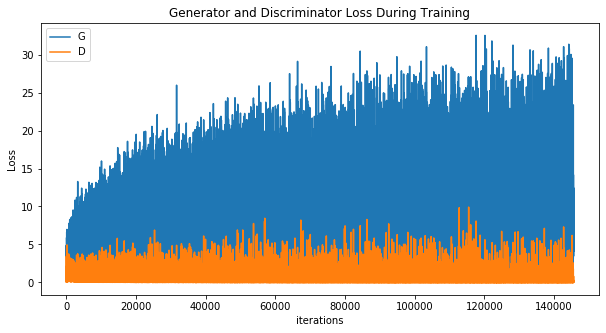

In [5]:
model.plot()

In [ ]:
# load model from file 
# load_dir = "models/GAN/model_states/version_0_10e/"
# model.load(load_dir)

In [15]:
noise = torch.randn(32, 100,1, 1, device=device)
img = model(noise)

In [16]:
def display_images(img):
    fig = plt.figure(figsize=(16,16))
    plt.axis("off")
    img_list = [vutils.make_grid(img, padding=2, normalize=True).cpu().detach()]

    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    plt.show()

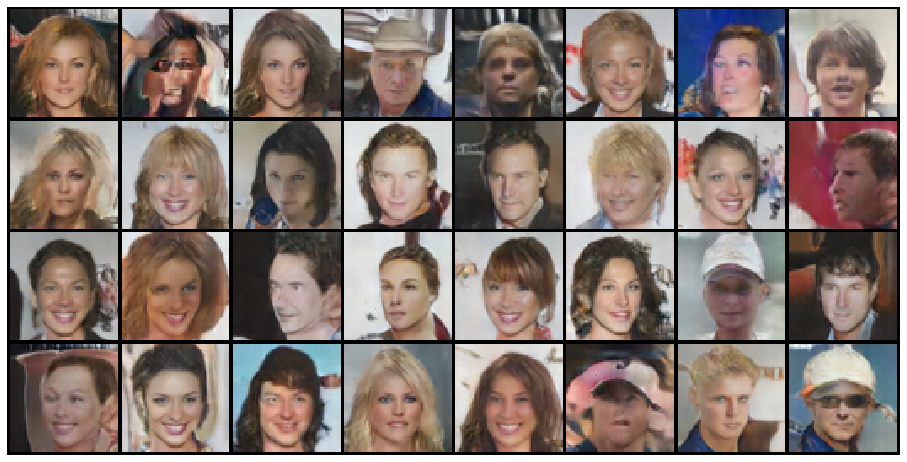

In [17]:
display_images(img)

## WGAN MODEL
### Train Model

In [ ]:
from models.WGAN.WGAN import WGAN 

save_dir = "models/WGAN/model_states/"


model = WGAN(device=device, save_dir=save_dir)
model.compile()

In [ ]:
g_epochs = 1000
d_epochs = 5

model.train(dataloader, g_epochs, d_epochs)

### Model analysis

In [ ]:
model.plot()

In [ ]:
noise = torch.randn(32, 100,1, 1, device=device)
img = model(noise)

In [ ]:
display_images(img)

## WGAN-GP
### Train Model

### Model analysis